# MSc in Data Analytics
# Sentiment Analysis Assignment - STEP 2


### Assignment
Topic: vaccine

this notebook will read the dataset containing only the tweeets related to vaccine.  
The dataset represent tweets from June 2020 until May 2021. **The dataset was downloaded from the link https://archive.org/details/twitterstream?sort=-publicdate**  


## Perform Sentiment Analysis

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col
import pyspark.sql.functions as F

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM

import plotly.subplots
from plotly.subplots import make_subplots


import numpy as np
import pandas as pd

import json, os

C:\Users\Mara\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Create the Spark Context

spark = SparkSession \
    .builder \
    .appName("sba22243-sentiment") \
    .config("spark.sql.debug.maxToStringFields", 100) \
    .config("spark.mongodb.input.uri", "mongodb://192.168.0.107/sba22243.vaccine") \
    .config("spark.mongodb.output.uri", "mongodb://192.168.0.107/sba22243.vaccine") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.2') \
    .getOrCreate()
sqlContext = spark._wrapped

### Read the tweets rady for processing from MongoDB

In [4]:
# Read tweets from MongoDB
df = sqlContext.read.format("mongo").option("uri", "mongodb://192.168.0.107/sba22243.vaccine").load()

In [5]:
df.show(5)

+--------------------+--------------------+---+----------+-----+--------------------+-------------+----+
|                 _id|          created_at|day| full_date|month|                text| timestamp_ms|year|
+--------------------+--------------------+---+----------+-----+--------------------+-------------+----+
|{646a9a4ee12bed28...|Tue Jun 09 13:01:...|  9|2020-06-09|    6|THE INJECTION FRA...|1591707677660|2020|
|{646a9a4ee12bed28...|Tue Jun 09 13:03:...|  9|2020-06-09|    6|Tests for Coronav...|1591707810659|2020|
|{646a9a4ee12bed28...|Tue Jun 09 13:36:...|  9|2020-06-09|    6|@EricTrump Not if...|1591709812659|2020|
|{646a9a4ee12bed28...|Tue Jun 09 13:38:...|  9|2020-06-09|    6|@gorygaming24601 ...|1591709885662|2020|
|{646a9a4ee12bed28...|Tue Jun 09 13:39:...|  9|2020-06-09|    6|Philippines Stude...|1591709982665|2020|
+--------------------+--------------------+---+----------+-----+--------------------+-------------+----+
only showing top 5 rows



In [6]:
# Convert spark dataframe into Pandas dataframe
pdf = df.toPandas()

In [7]:
pdf.head()

,_id,created_at,day,full_date,month,text,timestamp_ms,year
0,"(646a9a4ee12bed28b0c85ca8,)",Tue Jun 09 13:01:17 +0000 2020,9,2020-06-09,6,THE INJECTION FRAUD - IT'S NOT A VACCINE\nBy C...,1591707677660,2020
1,"(646a9a4ee12bed28b0c85cab,)",Tue Jun 09 13:03:30 +0000 2020,9,2020-06-09,6,Tests for Coronavirus Vaccine Need This Ingred...,1591707810659,2020
2,"(646a9a4ee12bed28b0c85caf,)",Tue Jun 09 13:36:52 +0000 2020,9,2020-06-09,6,@EricTrump Not if your father doesn't wake up ...,1591709812659,2020
3,"(646a9a4ee12bed28b0c85cb1,)",Tue Jun 09 13:38:05 +0000 2020,9,2020-06-09,6,@gorygaming24601 So do I... oh wait right I fo...,1591709885662,2020
4,"(646a9a4ee12bed28b0c85cb3,)",Tue Jun 09 13:39:42 +0000 2020,9,2020-06-09,6,Philippines Students Face Distance Learning Un...,1591709982665,2020


## Sentiment Analysis

In [8]:
# Load the Vader Lexicon
nltk.download(["vader_lexicon",
             "stopwords"])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mara\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
analyzer = SentimentIntensityAnalyzer()

### Text Preprocessor

In [10]:
stp_english = stopwords.words('english')
# Make text preprocessor
def tweet_preprocessor(tweet_text):
    token_list = word_tokenize(tweet_text.lower())
    token_without_stop_words = [token for token in token_list if token not in stp_english]
    
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in token_without_stop_words]

    final_tweet = " ".join(tokens_lemmatized)
    return final_tweet

In [11]:
pdf['text_filtered'] = pdf['text'].apply(lambda x: tweet_preprocessor(x))

### Polarity Extraction

In [12]:
pdf.head()

,_id,created_at,day,full_date,month,text,timestamp_ms,year,text_filtered
0,"(646a9a4ee12bed28b0c85ca8,)",Tue Jun 09 13:01:17 +0000 2020,9,2020-06-09,6,THE INJECTION FRAUD - IT'S NOT A VACCINE\nBy C...,1591707677660,2020,injection fraud - 's vaccine catherine austin ...
1,"(646a9a4ee12bed28b0c85cab,)",Tue Jun 09 13:03:30 +0000 2020,9,2020-06-09,6,Tests for Coronavirus Vaccine Need This Ingred...,1591707810659,2020,test coronavirus vaccine need ingredient : hor...
2,"(646a9a4ee12bed28b0c85caf,)",Tue Jun 09 13:36:52 +0000 2020,9,2020-06-09,6,@EricTrump Not if your father doesn't wake up ...,1591709812659,2020,@ erictrump father n't wake forced vaccine bla...
3,"(646a9a4ee12bed28b0c85cb1,)",Tue Jun 09 13:38:05 +0000 2020,9,2020-06-09,6,@gorygaming24601 So do I... oh wait right I fo...,1591709885662,2020,@ gorygaming24601 ... oh wait right forgot tak...
4,"(646a9a4ee12bed28b0c85cb3,)",Tue Jun 09 13:39:42 +0000 2020,9,2020-06-09,6,Philippines Students Face Distance Learning Un...,1591709982665,2020,philippine student face distance learning covi...


In [13]:
pdf['sentiment_compound'] = pdf['text_filtered'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [14]:
pdf.head()

,_id,created_at,day,full_date,month,text,timestamp_ms,year,text_filtered,sentiment_compound
0,"(646a9a4ee12bed28b0c85ca8,)",Tue Jun 09 13:01:17 +0000 2020,9,2020-06-09,6,THE INJECTION FRAUD - IT'S NOT A VACCINE\nBy C...,1591707677660,2020,injection fraud - 's vaccine catherine austin ...,-0.5859
1,"(646a9a4ee12bed28b0c85cab,)",Tue Jun 09 13:03:30 +0000 2020,9,2020-06-09,6,Tests for Coronavirus Vaccine Need This Ingred...,1591707810659,2020,test coronavirus vaccine need ingredient : hor...,0.0000
2,"(646a9a4ee12bed28b0c85caf,)",Tue Jun 09 13:36:52 +0000 2020,9,2020-06-09,6,@EricTrump Not if your father doesn't wake up ...,1591709812659,2020,@ erictrump father n't wake forced vaccine bla...,0.3570
3,"(646a9a4ee12bed28b0c85cb1,)",Tue Jun 09 13:38:05 +0000 2020,9,2020-06-09,6,@gorygaming24601 So do I... oh wait right I fo...,1591709885662,2020,@ gorygaming24601 ... oh wait right forgot tak...,0.0000
4,"(646a9a4ee12bed28b0c85cb3,)",Tue Jun 09 13:39:42 +0000 2020,9,2020-06-09,6,Philippines Students Face Distance Learning Un...,1591709982665,2020,philippine student face distance learning covi...,0.0000


In [15]:
pdf['sentiment'] = np.where(pdf['sentiment_compound'] >= 0.05, 'Positive', np.where((pdf['sentiment_compound'] > -0.05) & (pdf['sentiment_compound'] < 0.05), 'Neutral', 'Negative'))

In [16]:
pdf.head()

,_id,created_at,day,full_date,month,text,timestamp_ms,year,text_filtered,sentiment_compound,sentiment
0,"(646a9a4ee12bed28b0c85ca8,)",Tue Jun 09 13:01:17 +0000 2020,9,2020-06-09,6,THE INJECTION FRAUD - IT'S NOT A VACCINE\nBy C...,1591707677660,2020,injection fraud - 's vaccine catherine austin ...,-0.5859,Negative
1,"(646a9a4ee12bed28b0c85cab,)",Tue Jun 09 13:03:30 +0000 2020,9,2020-06-09,6,Tests for Coronavirus Vaccine Need This Ingred...,1591707810659,2020,test coronavirus vaccine need ingredient : hor...,0.0000,Neutral
2,"(646a9a4ee12bed28b0c85caf,)",Tue Jun 09 13:36:52 +0000 2020,9,2020-06-09,6,@EricTrump Not if your father doesn't wake up ...,1591709812659,2020,@ erictrump father n't wake forced vaccine bla...,0.3570,Positive
3,"(646a9a4ee12bed28b0c85cb1,)",Tue Jun 09 13:38:05 +0000 2020,9,2020-06-09,6,@gorygaming24601 So do I... oh wait right I fo...,1591709885662,2020,@ gorygaming24601 ... oh wait right forgot tak...,0.0000,Neutral
4,"(646a9a4ee12bed28b0c85cb3,)",Tue Jun 09 13:39:42 +0000 2020,9,2020-06-09,6,Philippines Students Face Distance Learning Un...,1591709982665,2020,philippine student face distance learning covi...,0.0000,Neutral


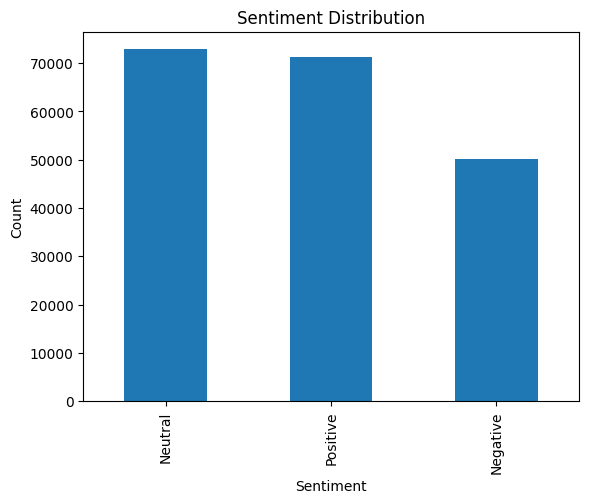

In [18]:
sentiment_counts = pdf['sentiment'].value_counts()
sentiment_counts.plot.bar()
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

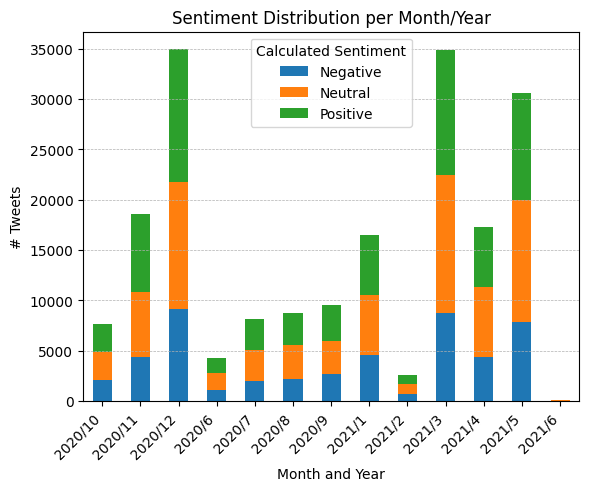

In [19]:
result_df = pdf.groupby(['year', 'month', 'sentiment'])['sentiment'].count().unstack('sentiment').fillna(0)
ax = result_df.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution per Month/Year')
plt.xlabel('Month and Year')
plt.ylabel('# Tweets')
plt.xticks(rotation=45, ha="right")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
xtick_labels = ['{}/{}'.format(int(year), int(month)) for year, month in result_df.index]
ax.set_xticklabels(xtick_labels)
ax.legend(title='Calculated Sentiment')
plt.show()

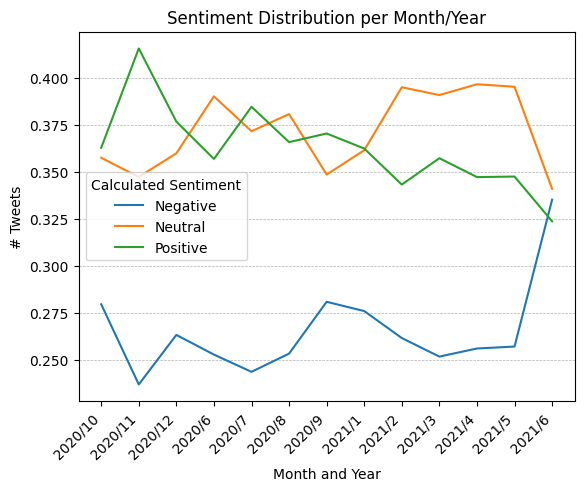

In [20]:
result_df = pdf.groupby(['year', 'month', 'sentiment'])['sentiment'].count().unstack('sentiment').fillna(0)
result_df = result_df.div(result_df.sum(axis=1), axis=0)
ax = result_df.plot(kind='line')
plt.title('Sentiment Distribution per Month/Year')
plt.xlabel('Month and Year')
plt.ylabel('# Tweets')
plt.xticks(rotation=45, ha="right")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
ax.xaxis.set_major_locator(mtick.FixedLocator([0,1,2,3,4,5,6,7,8,9,10,11,12]))
xtick_labels = ['{}/{}'.format(int(year), int(month)) for year, month in result_df.index]
ax.set_xticklabels(xtick_labels)
ax.legend(title='Calculated Sentiment')
plt.show()

## Time Series Analysis

In [21]:
# data preparation for timeseries
time_series_df = pdf.copy(deep=True)
time_series_df.drop_duplicates(subset=['timestamp_ms'], keep='last', inplace=True)
time_series_df = time_series_df.loc[:, ['timestamp_ms', 'sentiment_compound']]

In [22]:
time_series_df['timestamp'] = pd.to_datetime(time_series_df['timestamp_ms'], unit='ms')
time_series_df = time_series_df.sort_values(by='timestamp', ascending=True)
time_series_df.head()

C:\Users\Mara\AppData\Local\Temp\ipykernel_24600\1804642336.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  time_series_df['timestamp'] = pd.to_datetime(time_series_df['timestamp_ms'], unit='ms')


,timestamp_ms,sentiment_compound,timestamp
1512,1590995006659,0.0000,2020-06-01 07:04:18.688
1513,1590997328663,0.0000,2020-06-01 07:41:26.912
1514,1590998284666,-0.4019,2020-06-01 07:58:55.488
1515,1590999372665,0.5337,2020-06-01 08:16:24.064
1516,1591000848665,-0.1779,2020-06-01 08:40:25.856


In [23]:
time_series_df.set_index('timestamp', inplace=True)

In [24]:
time_series_df.head()

,timestamp_ms,sentiment_compound
timestamp,,
2020-06-01 07:04:18.688,1590995006659,0.0000
2020-06-01 07:41:26.912,1590997328663,0.0000
2020-06-01 07:58:55.488,1590998284666,-0.4019
2020-06-01 08:16:24.064,1590999372665,0.5337
2020-06-01 08:40:25.856,1591000848665,-0.1779


In [25]:
def plot_df(x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red', linewidth = '0.7')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
    plt.show()

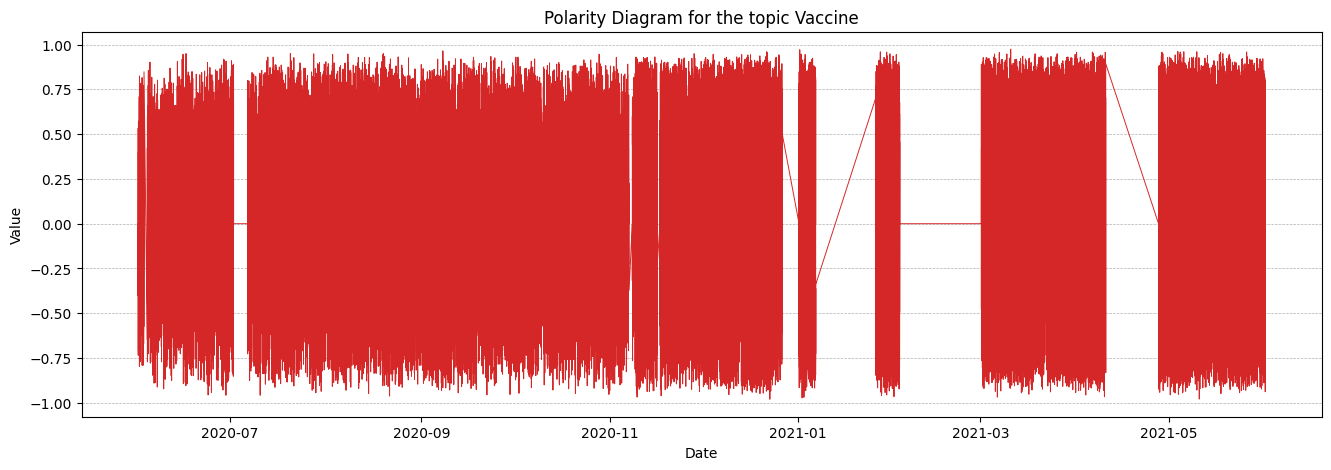

In [26]:
plot_df(x=time_series_df.index, y=time_series_df['sentiment_compound'], title='Polarity Diagram for the topic Vaccine')

In [27]:
# Resampling
time_series_df = time_series_df.resample('1d').mean()
#time_series_df.dropna(how='all', inplace=True)
time_series_df.head()

,timestamp_ms,sentiment_compound
timestamp,,
2020-06-01,inf,0.049651
2020-06-02,inf,0.012126
2020-06-03,inf,0.131870
2020-06-04,inf,0.064276
2020-06-05,inf,0.036946


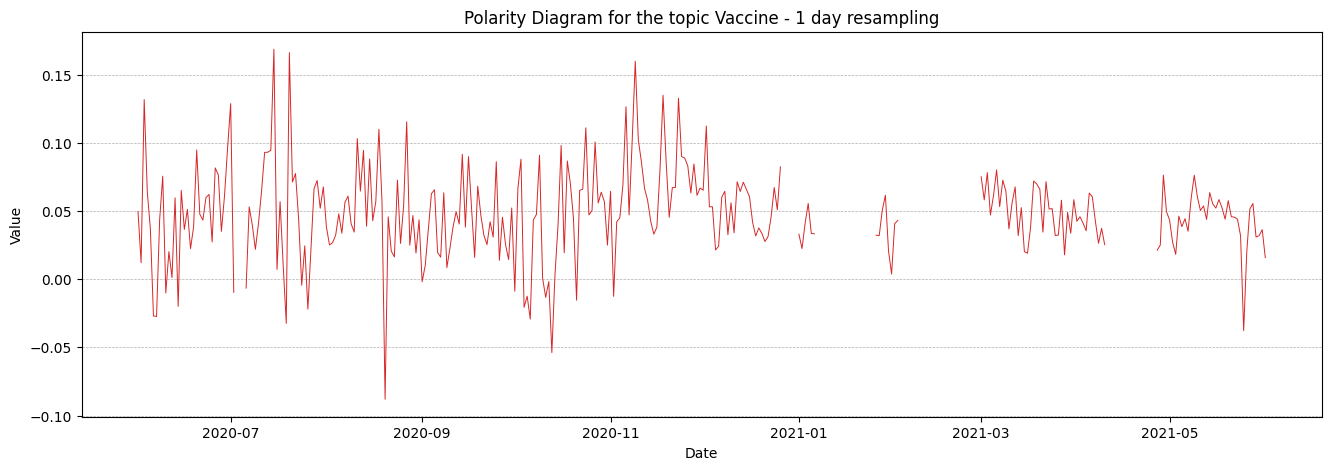

In [28]:
plot_df(x=time_series_df.index, y=time_series_df['sentiment_compound'], title='Polarity Diagram for the topic Vaccine - 1 day resampling')

In [29]:
# Fill Null values
time_series_df = time_series_df.bfill()

In [30]:
# add +1 to sentiment_compound
time_series_df['sentiment_compound'] = time_series_df['sentiment_compound'] + 1

### Autocorrelation and Partial Autocorrelation

C:\Users\Mara\anaconda3\envs\tf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


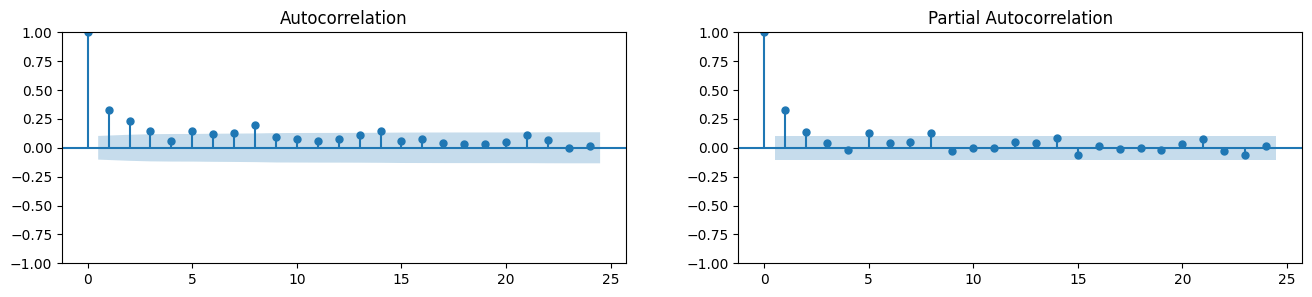

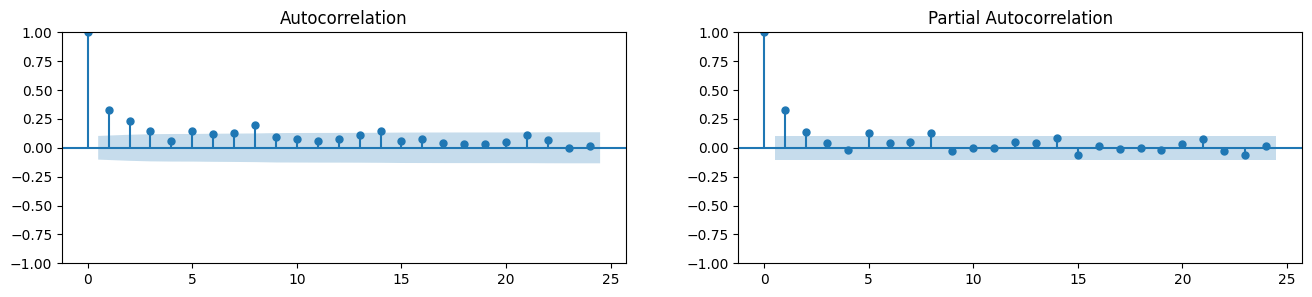

In [31]:
values = time_series_df['sentiment_compound'].tolist()

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(values, lags=24, ax=axes[0])
plot_pacf(values, lags=24, ax=axes[1])

### Decomposition 

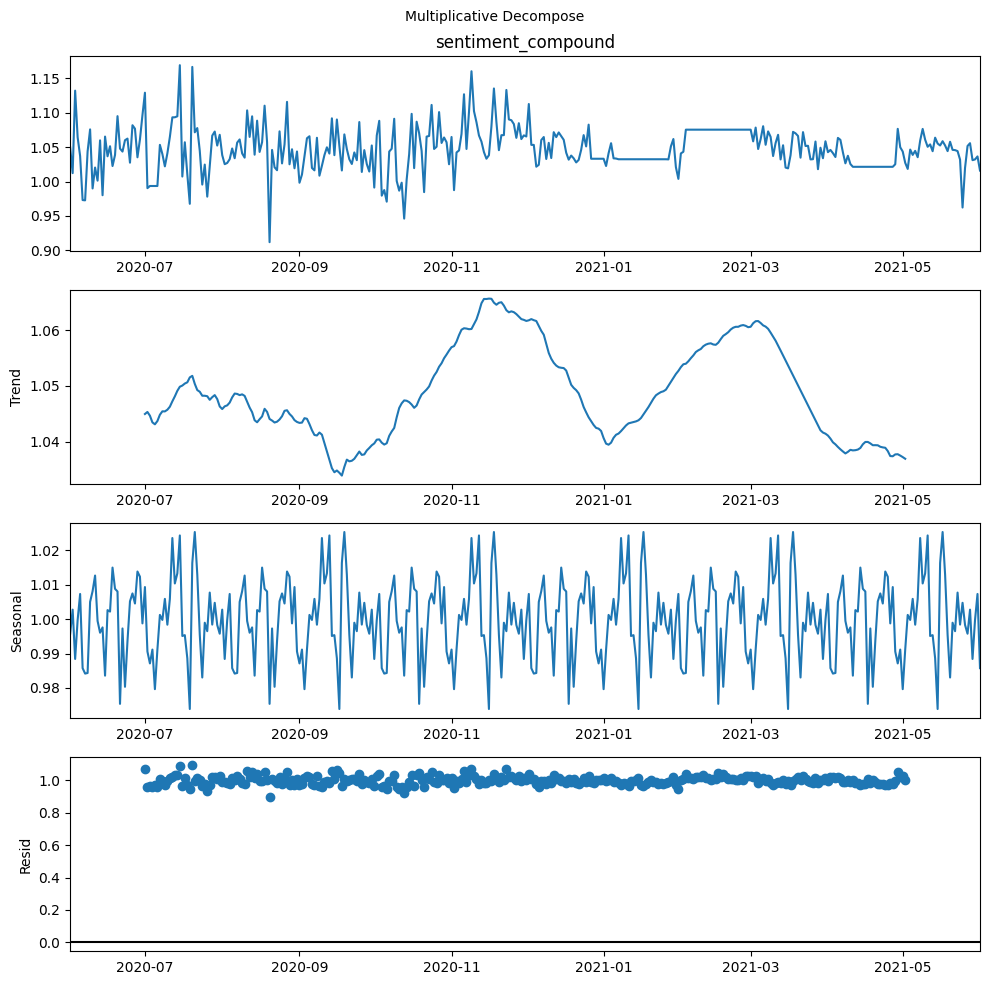

In [32]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(time_series_df['sentiment_compound'], model='multiplicative', period=60)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=10)
plt.tight_layout()
plt.show()

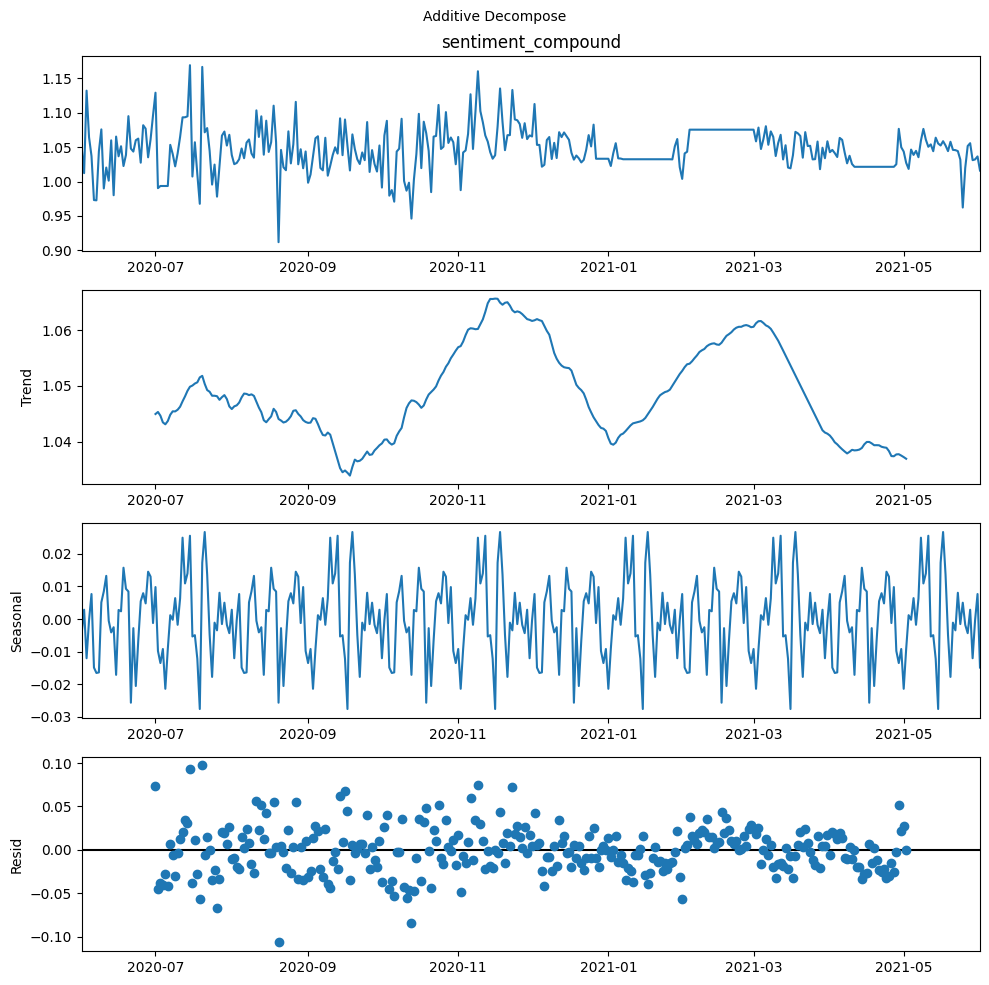

In [33]:
# Additive Decomposition
result_add = seasonal_decompose(time_series_df['sentiment_compound'], model='additive', period=60)
result_add.plot().suptitle('Additive Decompose', fontsize=10)
plt.tight_layout()
plt.show()

### Stationary and Non-Stationary Time Series

Using ADF and KPSS methots to test if the time series is stationary or not

In [34]:
# ADF Test
result = adfuller(time_series_df['sentiment_compound'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(time_series_df['sentiment_compound'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.298732172575729
p-value: 0.0004464633342597592
Critial Values:
   1%, -3.448748905151901
Critial Values:
   5%, -2.8696473721448728
Critial Values:
   10%, -2.5710891239349585

KPSS Statistic: 0.138466
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\Mara\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [35]:
# forecastability of a time series

# https://en.wikipedia.org/wiki/Sample_entropy
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(time_series_df['sentiment_compound'].array, m=2, r=0.2*np.std(time_series_df['sentiment_compound'].array)))   

0.7357953493290316


# Prediction

## Data Preparation

In [36]:
time_series_df.count()

timestamp_ms          366
sentiment_compound    366
dtype: int64

In [37]:
print(f'Number of rows with missing values: {time_series_df.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


## Prediction for 7 Days

Train dates : 2020-06-01 00:00:00 --- 2021-05-25 00:00:00  (n=359)
Test dates  : 2021-05-26 00:00:00 --- 2021-06-01 00:00:00  (n=7)


Text(0.5, 0, 'Date')

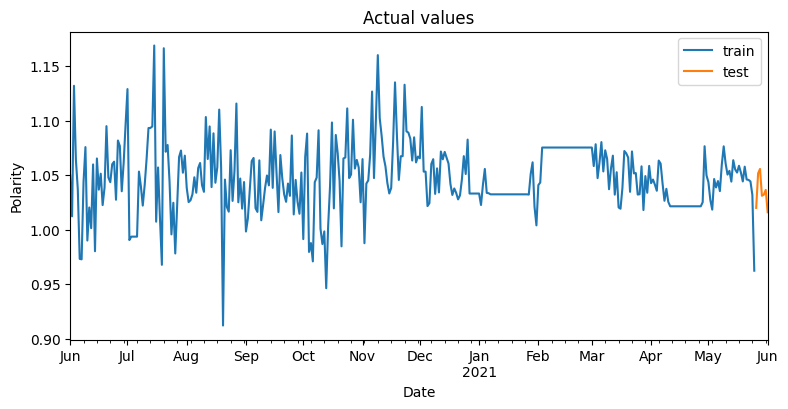

In [38]:
# Split data into train-test
# ==============================================================================
steps = 7
data_train = time_series_df[:-steps]
data_test  = time_series_df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['sentiment_compound'].plot(ax=ax, label='train')
data_test['sentiment_compound'].plot(ax=ax, label='test')
ax.legend();
ax.set_title('Actual values')
ax.set_ylabel('Polarity')
ax.set_xlabel('Date')

Test error (mse): 0.00038918895713819693


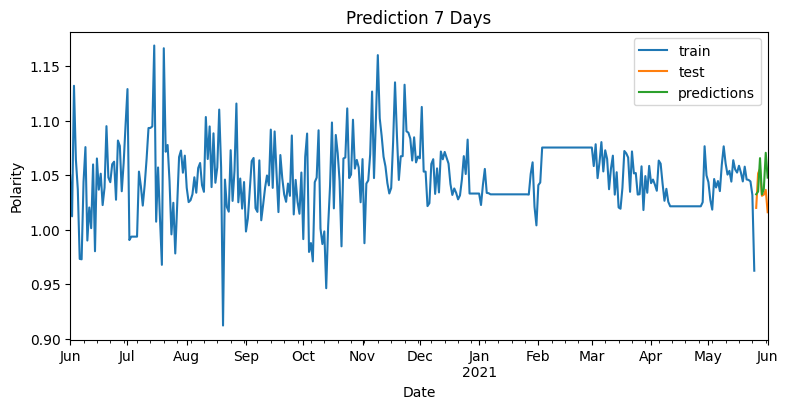

In [39]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['sentiment_compound'])
forecaster

# Predictions
# ==============================================================================
steps = 7
predictions_7days = forecaster.predict(steps=7)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['sentiment_compound'].plot(ax=ax, label='train')
data_test['sentiment_compound'].plot(ax=ax, label='test')
predictions_7days.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Prediction 7 Days')
ax.set_ylabel('Polarity')
ax.set_xlabel('Date')

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sentiment_compound'],
                y_pred = predictions_7days
            )

print(f"Test error (mse): {error_mse}")

In [40]:
# Hyperparameter tuning

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['sentiment_compound'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )


Number of models compared: 12.


lags grid: 100%|██████████| 2/2 [06:57<00:00, 208.76s/it] 


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.00034881797977142113



Test error (mse): 0.0002456481199325701


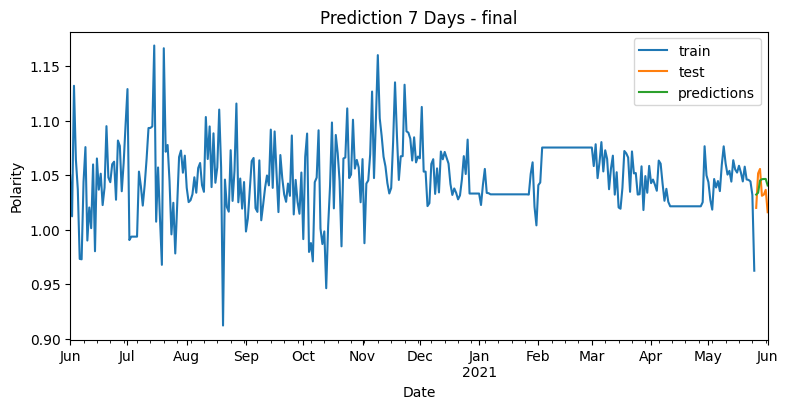

In [41]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['sentiment_compound'])

# Predictions
# ==============================================================================
predictions_7days = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['sentiment_compound'].plot(ax=ax, label='train')
data_test['sentiment_compound'].plot(ax=ax, label='test')
predictions_7days.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Prediction 7 Days - final')
ax.set_ylabel('Polarity')
ax.set_xlabel('Date')

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sentiment_compound'],
                y_pred = predictions_7days
                )

print(f"Test error (mse): {error_mse}")

## Prediction for 30 Days

Train dates : 2020-06-01 00:00:00 --- 2021-05-02 00:00:00  (n=336)
Test dates  : 2021-05-03 00:00:00 --- 2021-06-01 00:00:00  (n=30)


Text(0.5, 0, 'Date')

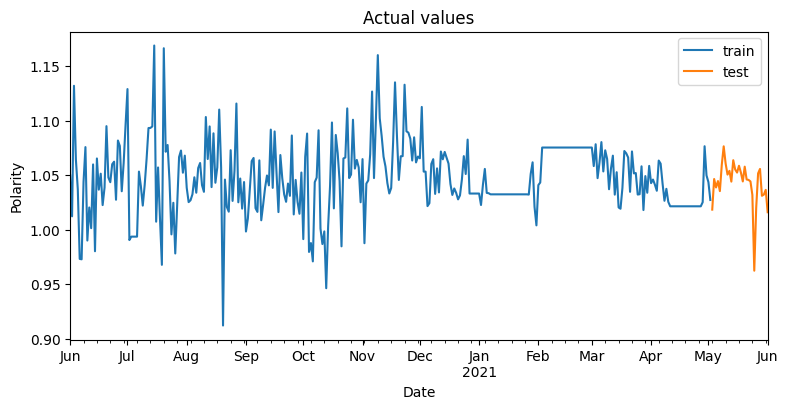

In [42]:
# Split data into train-test
# ==============================================================================
steps = 30
data_train = time_series_df[:-steps]
data_test  = time_series_df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['sentiment_compound'].plot(ax=ax, label='train')
data_test['sentiment_compound'].plot(ax=ax, label='test')
ax.legend();
ax.set_title('Actual values')
ax.set_ylabel('Polarity')
ax.set_xlabel('Date')

Test error (mse): 0.000436667245894054


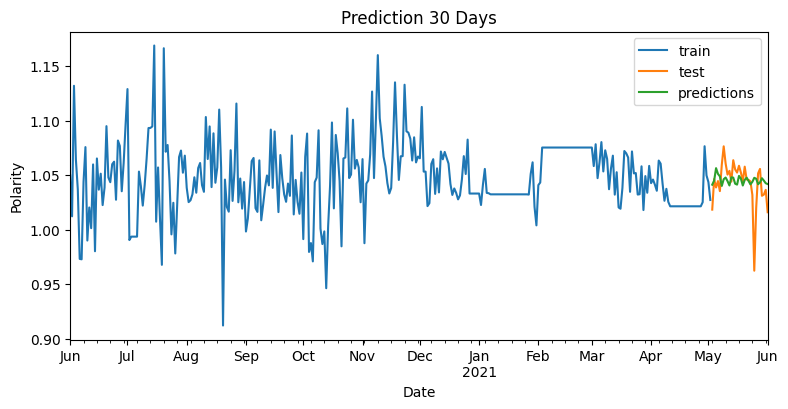

In [43]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['sentiment_compound'])
forecaster

# Predictions
# ==============================================================================
predictions_30days = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['sentiment_compound'].plot(ax=ax, label='train')
data_test['sentiment_compound'].plot(ax=ax, label='test')
predictions_30days.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Prediction 30 Days')
ax.set_ylabel('Polarity')
ax.set_xlabel('Date')

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sentiment_compound'],
                y_pred = predictions_30days
            )

print(f"Test error (mse): {error_mse}")

In [44]:
# Hyperparameter tuning

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['sentiment_compound'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )


Number of models compared: 12.


lags grid: 100%|██████████| 2/2 [02:17<00:00, 68.78s/it]  


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.00048427017165102393



Test error (mse): 0.0004043424974692983


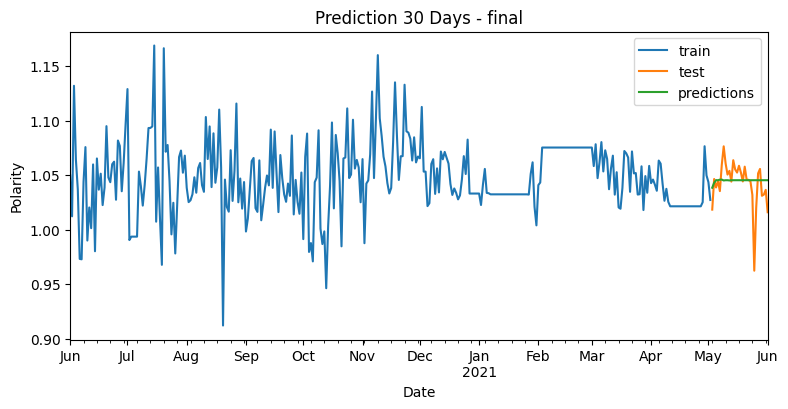

In [45]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster.fit(y=data_train['sentiment_compound'])

# Predictions
# ==============================================================================
predictions_30days = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['sentiment_compound'].plot(ax=ax, label='train')
data_test['sentiment_compound'].plot(ax=ax, label='test')
predictions_30days.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Prediction 30 Days - final')
ax.set_ylabel('Polarity')
ax.set_xlabel('Date')

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sentiment_compound'],
                y_pred = predictions_30days
                )

print(f"Test error (mse): {error_mse}")

## Prediction for 90 Days

Train dates : 2020-06-01 00:00:00 --- 2021-03-03 00:00:00  (n=276)
Test dates  : 2021-03-04 00:00:00 --- 2021-06-01 00:00:00  (n=90)


Text(0.5, 0, 'Date')

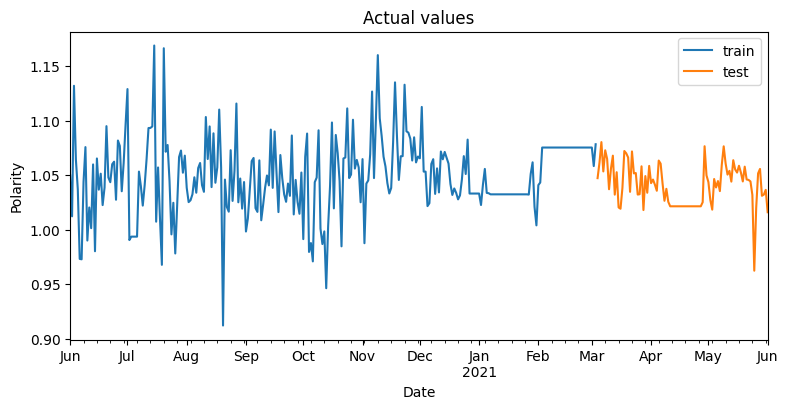

In [46]:
# Split data into train-test
# ==============================================================================
steps = 90
data_train = time_series_df[:-steps]
data_test  = time_series_df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['sentiment_compound'].plot(ax=ax, label='train')
data_test['sentiment_compound'].plot(ax=ax, label='test')
ax.legend();
ax.set_title('Actual values')
ax.set_ylabel('Polarity')
ax.set_xlabel('Date')

Test error (mse): 0.0014843682643494113


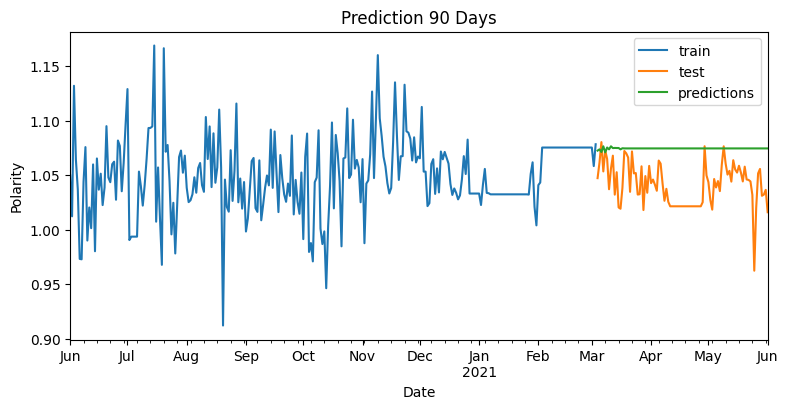

In [47]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['sentiment_compound'])
forecaster

# Predictions
# ==============================================================================
predictions_90days = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['sentiment_compound'].plot(ax=ax, label='train')
data_test['sentiment_compound'].plot(ax=ax, label='test')
predictions_90days.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Prediction 90 Days')
ax.set_ylabel('Polarity')
ax.set_xlabel('Date')

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sentiment_compound'],
                y_pred = predictions_90days
            )

print(f"Test error (mse): {error_mse}")

In [48]:
# Hyperparameter tuning

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['sentiment_compound'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )


Number of models compared: 12.


lags grid: 100%|██████████| 2/2 [01:03<00:00, 31.87s/it]  


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.0007594647958338267



Test error (mse): 0.001371608729892386


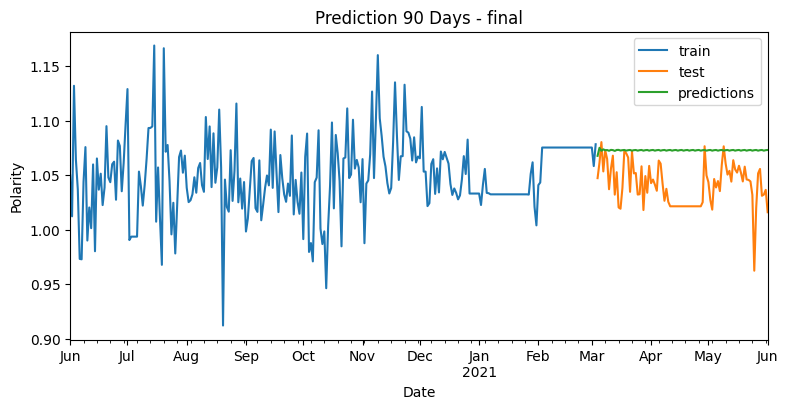

In [49]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster.fit(y=data_train['sentiment_compound'])

# Predictions
# ==============================================================================
predictions_90days = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['sentiment_compound'].plot(ax=ax, label='train')
data_test['sentiment_compound'].plot(ax=ax, label='test')
predictions_90days.plot(ax=ax, label='predictions')
ax.legend();
ax.set_title('Prediction 90 Days - final')
ax.set_ylabel('Polarity')
ax.set_xlabel('Date')

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['sentiment_compound'],
                y_pred = predictions_90days
                )

print(f"Test error (mse): {error_mse}")